In [254]:
import statsmodels.tsa.holtwinters as hw
import statsmodels.tsa.statespace.exponential_smoothing as hw_ss
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from scipy.optimize import curve_fit
import datetime as dt
import matplotlib.pyplot as plt

In [255]:
us_data = pd.read_csv("../covid-tracking-data/data/us_daily.csv", index_col="date", parse_dates=["date"])[::-1]

start_date = pd.to_datetime("20200228")
#end_date = pd.to_datetime   ("20200420")
end_date = us_data.index[-1]
us_data = us_data[(us_data.index >= start_date) & (us_data.index <= end_date)]

In [256]:
us_data

,states,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,onVentilatorCumulative,recovered,hash,dateChecked,death,hospitalized,total,totalTestResults,posNeg,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease
date,,,,,,,,,,,,,,,,,,,,,,,
2020-02-28,1,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7de1cbe8b7b0a50a3afdd4b9c4d69ff78318681e,2020-02-28T21:00:00Z,4.0,NaN,9,9,9,4.0,0.0,0.0,7.0,7.0
2020-02-29,1,18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,243260e18d47e670dade08ee5a5195fcc8b5a9db,2020-02-29T21:00:00Z,5.0,NaN,18,18,18,1.0,0.0,0.0,9.0,9.0
2020-03-01,3,40,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ca260a1247d2b0574d24373499373db27272de6e,2020-03-01T21:00:00Z,8.0,NaN,40,40,40,3.0,0.0,0.0,22.0,22.0
2020-03-02,3,53,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6513d03460ba39e3593914dcf26e9686a6102c3a,2020-03-02T21:00:00Z,11.0,NaN,53,53,53,3.0,0.0,0.0,13.0,13.0
2020-03-03,3,94,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,86770db4d6896557717aeae87fff9e3b90548964,2020-03-03T21:00:00Z,14.0,NaN,100,100,100,3.0,0.0,6.0,41.0,47.0
2020-03-04,16,209,759.0,103.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,469fa0e70ed7d25e9989fc688df5f75ebb22cb54,2020-03-04T21:00:00Z,16.0,NaN,1071,968,968,2.0,0.0,753.0,115.0,868.0
2020-03-05,25,277,970.0,197.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,768dda12019c1c607c700e84339f3bd87c900dbd,2020-03-05T21:00:00Z,20.0,NaN,1444,1247,1247,4.0,0.0,211.0,68.0,279.0
2020-03-06,37,395,1588.0,458.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16267a92330f7d42a4d88b8dc381bcb09b0170e6,2020-03-06T21:00:00Z,26.0,NaN,2441,1983,1983,6.0,0.0,618.0,118.0,736.0
2020-03-07,51,551,1839.0,602.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,e92591fefd3041aea638f41d7849f63abeda92c0,2020-03-07T21:00:00Z,27.0,NaN,2992,2390,2390,1.0,0.0,251.0,156.0,407.0


In [257]:
#end_date = pd.to_datetime('20200420')
end_date = us_data.index[-1]

params = []
for t, d in [('mul', True), ('mul', False), ('add', True), ('add', False)]:
    es = hw.ExponentialSmoothing(
        us_data['positive'][(us_data.index <= end_date)],
        trend=t,
        freq='D',
        damped=d,
    )
    fit = es.fit()
    params.append((fit.sse, fit, es, t, d))
    print("Trend: %s, Damped: %s, SSE: %f" % (t,d,fit.sse))
    
best = min(params)
best_fit = best[1]
best_model = best[2]
print('Selecting: Trend: %s, Damped: %s, SSE: %f ' % (best[3], best[4], best[0]))

Trend: mul, Damped: True, SSE: 383200447.527264
Trend: mul, Damped: False, SSE: 468382572.889330
Trend: add, Damped: True, SSE: 376037550.410559
Trend: add, Damped: False, SSE: 375907719.243502
Selecting: Trend: add, Damped: False, SSE: 375907719.243502 


/home/beala/.local/lib/python3.6/site-packages/statsmodels/tsa/holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/home/beala/.local/lib/python3.6/site-packages/statsmodels/tsa/holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/home/beala/.local/lib/python3.6/site-packages/statsmodels/tsa/holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


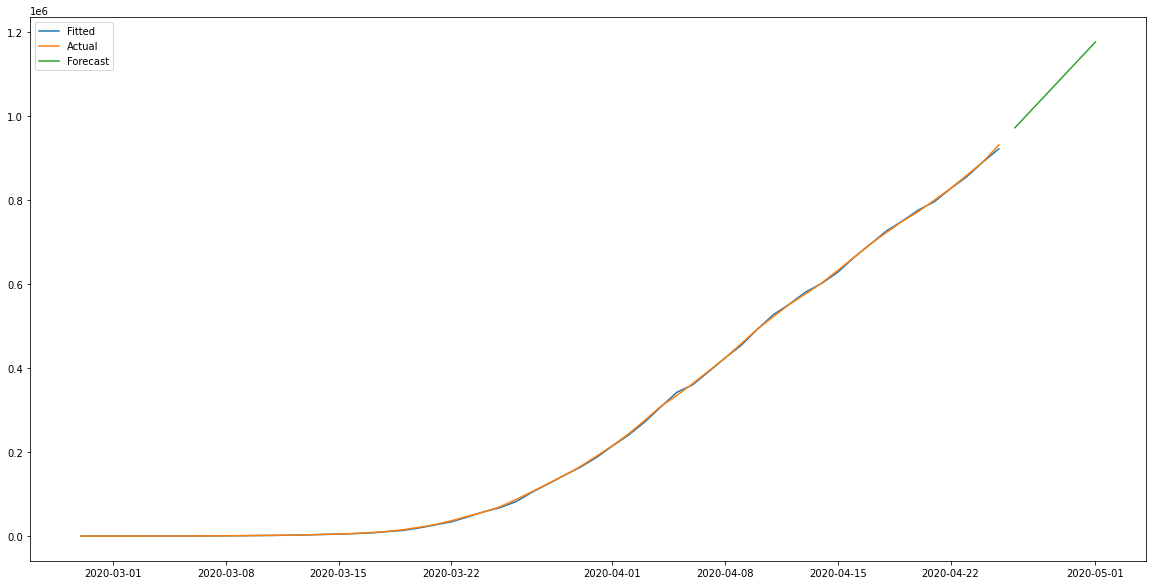

In [258]:
fig, ax = plt.subplots(figsize=(20,10))

ax.plot(best_fit.fittedvalues, label="Fitted")
ax.plot(us_data['positive'], label="Actual")

ax.plot(best_fit.forecast(6), label="Forecast")
plt.legend()

#fit1.params_formatted

In [259]:
best_fit.forecast(6).index[-1]

Timestamp('2020-05-01 00:00:00', freq='D')

In [260]:
pd.to_datetime('2020-04-01') + pd.to_timedelta('1 day')

delta = us_data.index[-1] - us_data.index[0]

delta.days

57

In [261]:
#end_date = pd.to_datetime('20200420')
end_date = us_data.index[-1]

results = []
# Search through different model params
for t, d in [('mul', True), ('mul', False), ('add', True), ('add', False)]:
    pct_errors = list()
    # Backtest by fitting a model and producing a 6 day
    # forecast for every day in our history.
    for day_offset in range(1, delta.days-5):
        end_date = us_data.index[0] + pd.to_timedelta('%d day' % day_offset)
        es = hw.ExponentialSmoothing(
            us_data['positive'][(us_data.index <= end_date)],
            trend=t,
            freq='D',
            damped=d,
        )
        fit = es.fit()
        f = fit.forecast(6)
        # Get the actual number for the forecast day
        actual = us_data[us_data.index == f.index[-1]]['positive']
        # Calculate the percent error of the forecast
        pct_error = (f[-1]-actual[0])/actual[0]
        #print("%s %s Actual: %d Forecast: %d Error: %.2f" % (end_date.strftime('%Y/%m/%d'), f.index[-1].strftime('%Y/%m/%d'), actual[0], f[-1], pct_error * 100))
        pct_errors.append(pct_error)
    results.append(((t,d),pct_errors))
    print(t,d)
    print(np.percentile((pct_errors[-30:]), q = [5, 10, 50, 90, 95]))
    

/home/beala/.local/lib/python3.6/site-packages/statsmodels/tsa/holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/home/beala/.local/lib/python3.6/site-packages/statsmodels/tsa/holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/home/beala/.local/lib/python3.6/site-packages/statsmodels/tsa/holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/home/beala/.local/lib/python3.6/site-packages/statsmodels/tsa/holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/home/beala/.local/lib/python3.6/site-packages/statsmodels/tsa/holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/home/beala/.local/lib/python3.6/site-packages/statsmodels/tsa/holtwinters.py:744: ConvergenceWarning: Optimization

mul True
[-0.16531757 -0.12772523 -0.00423272  0.23983559  0.38606495]


/home/beala/.local/lib/python3.6/site-packages/statsmodels/tsa/holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/home/beala/.local/lib/python3.6/site-packages/statsmodels/tsa/holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/home/beala/.local/lib/python3.6/site-packages/statsmodels/tsa/holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/home/beala/.local/lib/python3.6/site-packages/statsmodels/tsa/holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/home/beala/.local/lib/python3.6/site-packages/statsmodels/tsa/holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/home/beala/.local/lib/python3.6/site-packages/statsmodels/tsa/holtwinters.py:744: ConvergenceWarning: Optimization

mul False
[0.00798837 0.0233689  0.12154812 0.48710949 0.54836716]


/home/beala/.local/lib/python3.6/site-packages/statsmodels/tsa/holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/home/beala/.local/lib/python3.6/site-packages/statsmodels/tsa/holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/home/beala/.local/lib/python3.6/site-packages/statsmodels/tsa/holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/home/beala/.local/lib/python3.6/site-packages/statsmodels/tsa/holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/home/beala/.local/lib/python3.6/site-packages/statsmodels/tsa/holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/home/beala/.local/lib/python3.6/site-packages/statsmodels/tsa/holtwinters.py:744: ConvergenceWarning: Optimization

add True
[-0.28240168 -0.24940649 -0.02926694  0.02744743  0.04202994]


/home/beala/.local/lib/python3.6/site-packages/statsmodels/tsa/holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/home/beala/.local/lib/python3.6/site-packages/statsmodels/tsa/holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/home/beala/.local/lib/python3.6/site-packages/statsmodels/tsa/holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/home/beala/.local/lib/python3.6/site-packages/statsmodels/tsa/holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/home/beala/.local/lib/python3.6/site-packages/statsmodels/tsa/holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/home/beala/.local/lib/python3.6/site-packages/statsmodels/tsa/holtwinters.py:744: ConvergenceWarning: Optimization

add False
[-0.28226301 -0.24926924 -0.0291428   0.02753037  0.04215662]


/home/beala/.local/lib/python3.6/site-packages/statsmodels/tsa/holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/home/beala/.local/lib/python3.6/site-packages/statsmodels/tsa/holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/home/beala/.local/lib/python3.6/site-packages/statsmodels/tsa/holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/home/beala/.local/lib/python3.6/site-packages/statsmodels/tsa/holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


('mul', True)
             0
0.05 -0.165318
0.10 -0.127725
0.50 -0.004233
0.90  0.239836
0.95  0.386065
('mul', False)
             0
0.05  0.007988
0.10  0.023369
0.50  0.121548
0.90  0.487109
0.95  0.548367
('add', True)
             0
0.05 -0.282402
0.10 -0.249406
0.50 -0.029267
0.90  0.027447
0.95  0.042030
('add', False)
             0
0.05 -0.282263
0.10 -0.249269
0.50 -0.029143
0.90  0.027530
0.95  0.042157


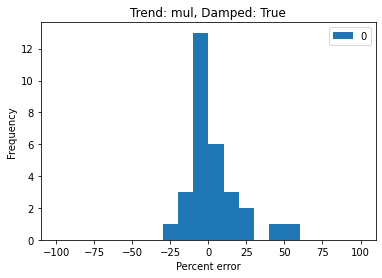

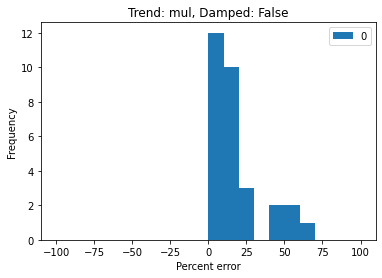

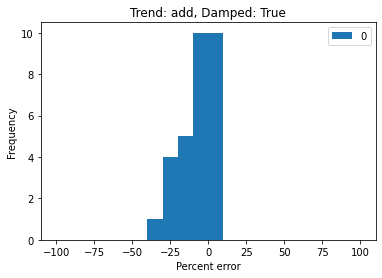

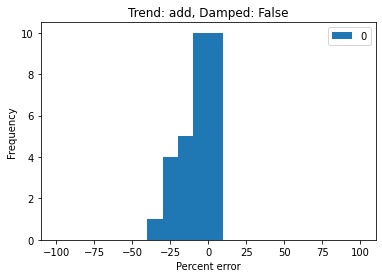

In [262]:
for (p, errors) in results:
    errors_df = pd.DataFrame(errors)[-30:]
    print(p)
    print(errors_df.quantile([.05,.10,.50,.90,.95]))
    ax = (errors_df * 100).plot(kind='hist', bins=range(-100,101,10), title='Trend: %s, Damped: %s' % (p[0],p[1]))
    ax.set_xlabel('Percent error')
    #print (p, errors)

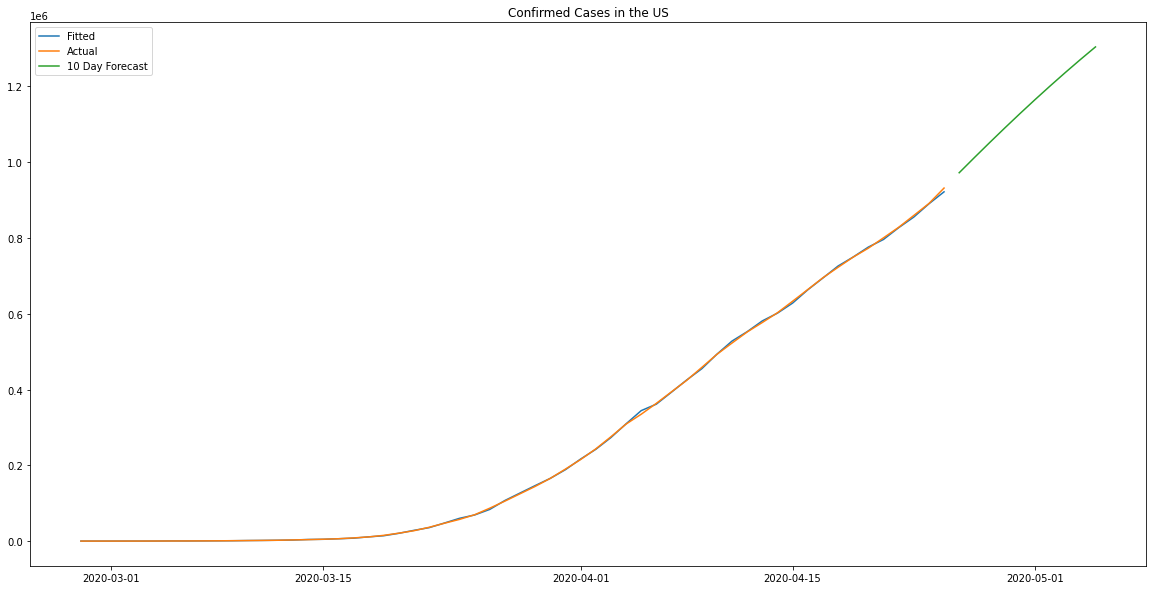

In [271]:
# 10 day forecast using multiplicative trend and dampening
es = hw.ExponentialSmoothing(
    us_data['positive'],
    trend='mul',
    freq='D',
    damped=True,
)
fit = es.fit(optimized=True)

fig, ax = plt.subplots(figsize=(20,10))

ax.plot(fit.fittedvalues, label="Fitted")
ax.plot(us_data['positive'], label="Actual")

ax.plot(fit.forecast(10), label="10 Day Forecast")
plt.title("Confirmed Cases in the US")
plt.yscale('linear')
plt.legend()

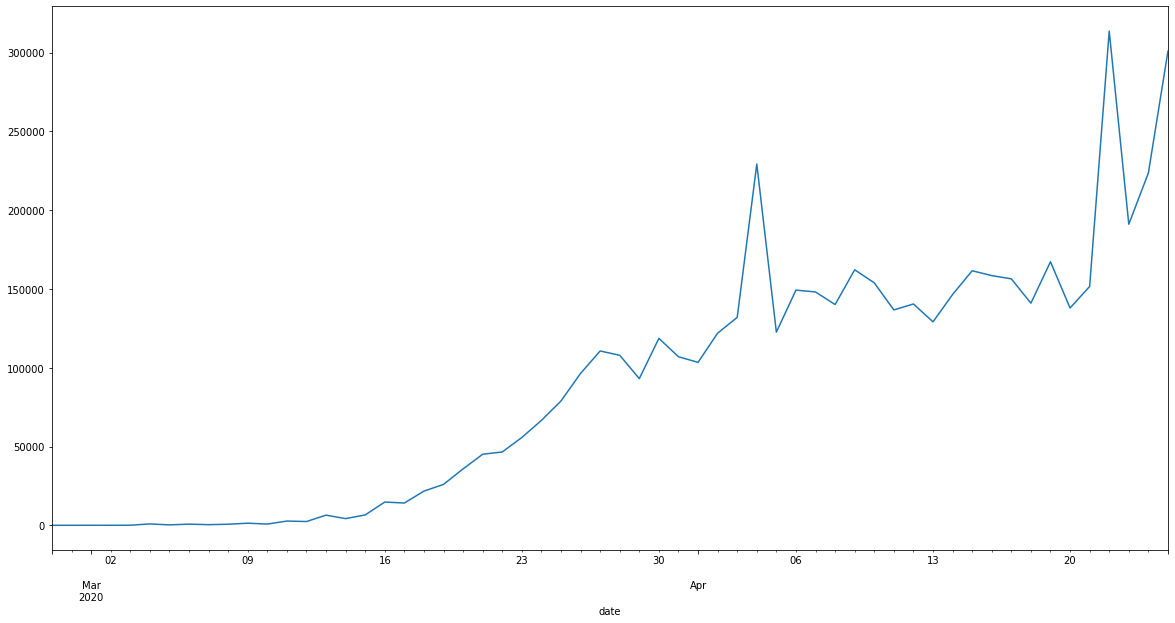

In [267]:
us_data['totalTestResultsIncrease'].plot(figsize=(20,10))